# Chapter 4: Relationship between Runs Scored and Wins

In [1]:
# this is where all my libraries will be stored

library('tidyverse')
library(Lahman)
library(broom)
library(ggrepel)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# We will be creating an analyzing a Linear Model to assess the impact and or magnitude that Runs have on the number of games that you will win in a season

## First, lets take the Lahman dataset and get the team information on all MLB teams from 2013 going forward

In [36]:
# get win pct for all years preceeding 2000 except 2020 season
Teams %>%
  filter(yearID >= 2000 & yearID != 2020) %>%
  select(teamID, yearID, G, W, L,R,RA) -> Teams_2000_beyond


View(head(Teams_2000_beyond, 5))

,teamID,yearID,G,W,L,R,RA
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,ANA,2000,162,82,80,864,869
2,ARI,2000,162,85,77,792,754
3,ATL,2000,162,95,67,810,714
4,BAL,2000,162,74,88,794,913
5,BOS,2000,162,85,77,792,745


## Next, lets get the Win Pct and the Run Differentials for every team

In [37]:


Teams_2000_beyond  %>%
  mutate(Run_diff = R- RA, Win_Pct = W/G) -> Teams_2000_beyond


View(head(Teams_2000_beyond, 5))

,teamID,yearID,G,W,L,R,RA,Run_diff,Win_Pct
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,ANA,2000,162,82,80,864,869,-5,0.5061728
2,ARI,2000,162,85,77,792,754,38,0.5246914
3,ATL,2000,162,95,67,810,714,96,0.5864198
4,BAL,2000,162,74,88,794,913,-119,0.4567901
5,BOS,2000,162,85,77,792,745,47,0.5246914


## Ok, now lets plot this and see if there is a linear relationship

`geom_smooth()` using formula = 'y ~ x'


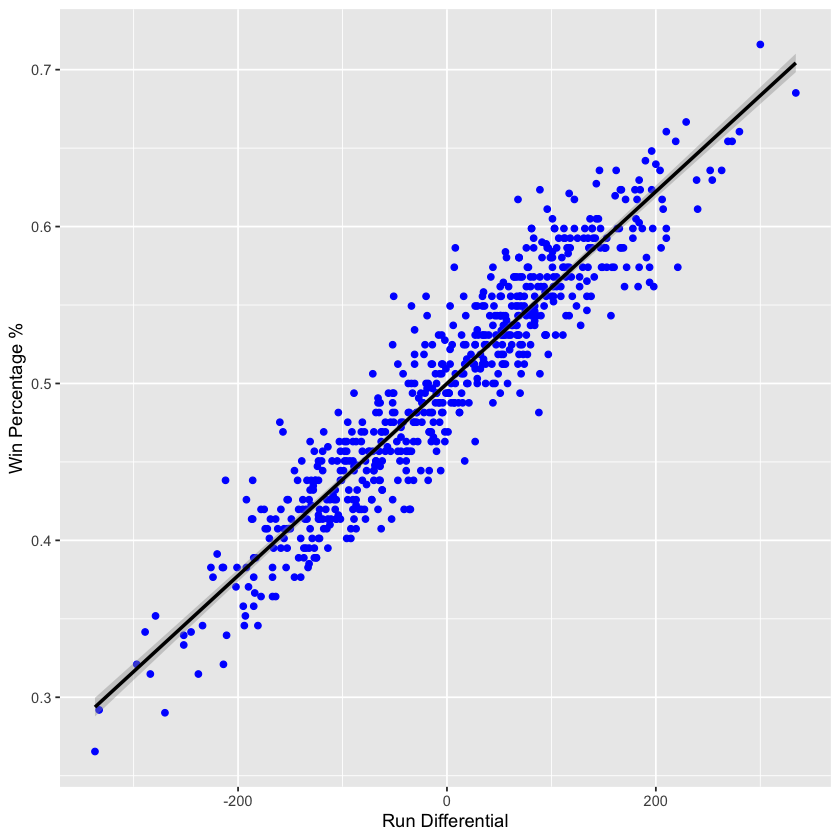

In [38]:

ggplot(data=Teams_2000_beyond, aes(x=Run_diff, y=Win_Pct))+
geom_point(color='blue')+
  geom_smooth(method="lm", color='black')+
labs(x='Run Differential', y='Win Percentage %')

## Also lets see the distribution of the dataset to see if this is normally distributed

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


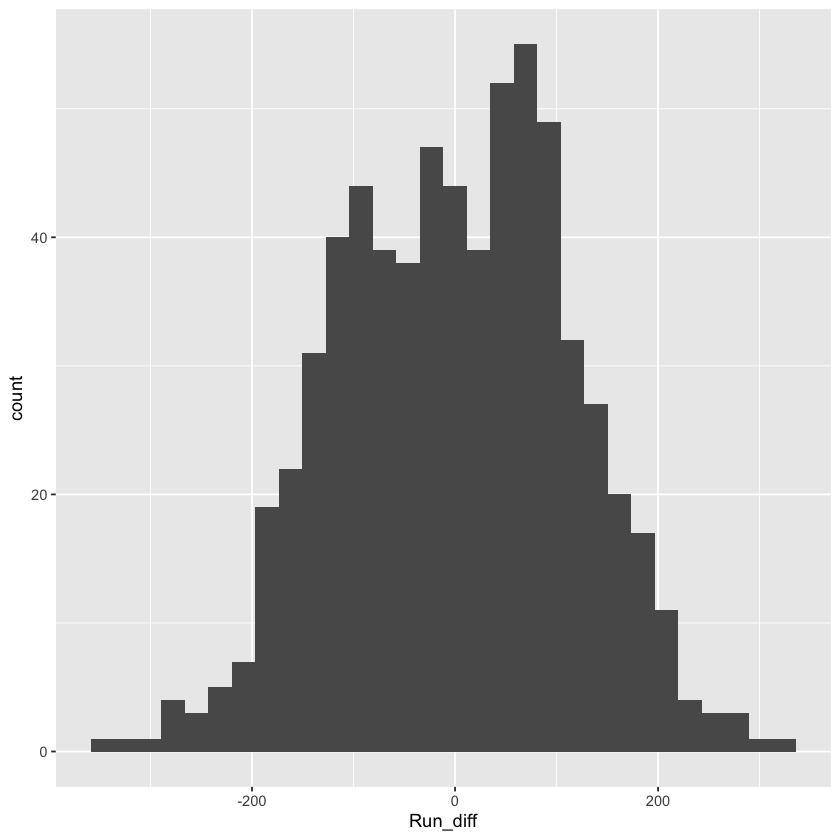

In [39]:
ggplot(data=Teams_2000_beyond, aes(x=Run_diff)) +
geom_histogram() 

## looks normally distributed

## As seen above, the Run differential and Win Percentage have a positive linear relationship between the two, ow less get the linear formula

In [40]:
# this creates a linear model with Response ~ predictors 
linfit <- lm(Win_Pct ~ Run_diff, data=Teams_2000_beyond)

linfit


Call:
lm(formula = Win_Pct ~ Run_diff, data = Teams_2000_beyond)

Coefficients:
(Intercept)     Run_diff  
  0.4999306    0.0006119  


## From this, you can see that a rough estimate for the linear model would be: y = .4999306 + .0006119x with y being win percentage and x being the run differential, which would suggest that a team with a 0 run differential should be expected to have about a 50% win percentage or win 81 games in a full 162 game season.

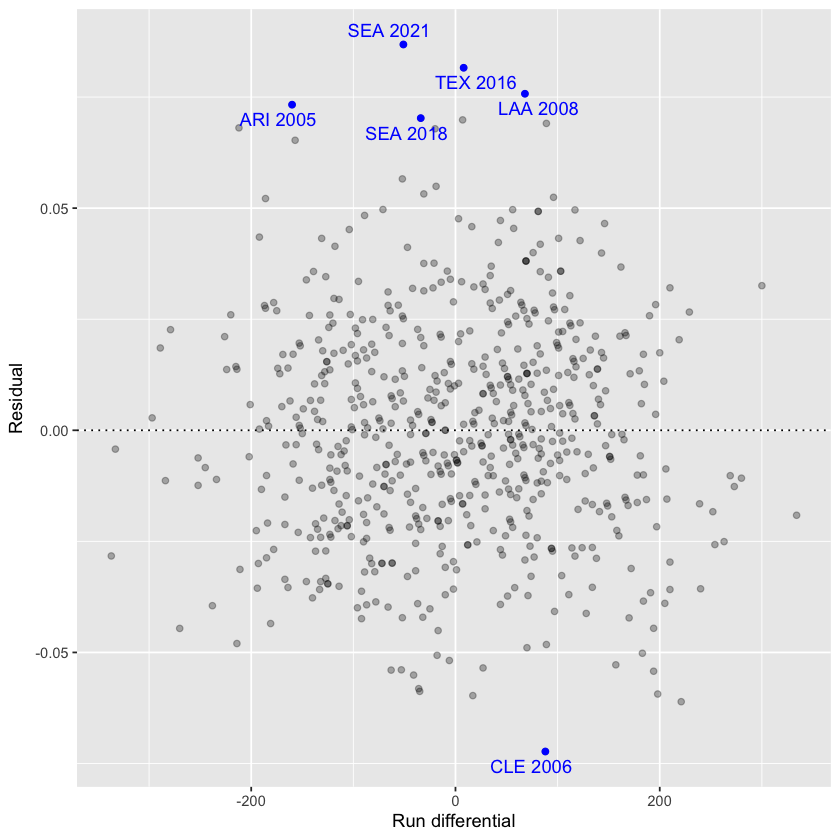

In [41]:
# this calculates residuals and other measures based on the linear model
my_teams_aug <- augment(linfit, data=Teams_2000_beyond)



# this plots all the residuals to get an idea of the distributed differences
base_plot <- ggplot(data=my_teams_aug, aes(x=Run_diff, y=.resid)) +
  geom_point(alpha = .3) +
  geom_hline(yintercept = 0, linetype=3) +
  xlab("Run differential" ) + ylab("Residual")
# this picks the highest residuals and selects those 6 points
highlight_teams <- my_teams_aug %>%
  arrange(desc(abs(.resid))) %>%
  head(6)


text_plot <- base_plot +
  geom_point(data=highlight_teams, color='blue') +
  geom_text_repel(data=highlight_teams, color='blue', aes(label=paste(teamID, yearID)))

text_plot

## Now we will evaluate this model by taking the Root Mean Squared Error

In [42]:
my_teams_aug %>%
summarize(N = n(),
          avg=  mean(.resid),
          rmse = sqrt(mean(.resid^2))
) -> rmse_result


rmse_result


rmse <- rmse_result %>%
pull(rmse)

N,avg,rmse
<int>,<dbl>,<dbl>
660,1.132893e-16,0.02498528


## Referencing the empirical rule, approximately  68% of the residuals should be within - rmse and 95% within -2 * rmse and 2 rmse and 99% between -3 rmse and 3 rmse, so lets test that to fully confirm the dataset is normally distributed like earlier in this document [Empirical Rule Wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)

In [43]:
my_teams_aug %>%
summarize(
  N = n(),
  within_one = sum(abs(.resid) < rmse),
  within_two = sum(abs(.resid)< 2*rmse),
  within_three = sum(abs(.resid)< 3*rmse)
) -> summary

summary %>%
  mutate(
    within_one_percentage = within_one / N,
    within_two_percentage = within_two / N,
    within_three_percentage = within_three / N,
    
  ) -> summary


summary

N,within_one,within_two,within_three,within_one_percentage,within_two_percentage,within_three_percentage
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
660,452,630,657,0.6848485,0.9545455,0.9954545


## From looking at the above numbers we can see that it matches the empirical rule and the residuals are confirmed normally distributed as well

# Pythagorean Formula for Win Percentage (Non-linear Formula)


## W pct = R^2 / (R^2 + RA^2)
### R --> Runs RA --> Runs Allowed

In [45]:
Teams_2013_beyond %>%
mutate(Win_Pct_Pythag = R^2 / (RA^2+ R^2)) -> Teams_2013_beyond -> Teams_2013_beyond


Teams_2013_beyond %>%
  mutate(residuals_pythag = Win_Pct_Pythag - Win_Pct) -> Teams_2013_beyond


head(Teams_2013_beyond,5)

,teamID,yearID,G,W,L,R,RA,Run_diff,Win_Pct,Win_Pct_Pythag,residuals_pythag
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,ARI,2013,162,81,81,685,695,-10,0.5000000,0.4927540,-7.245996e-03
2,ATL,2013,162,96,66,688,548,140,0.5925926,0.6118338,1.924121e-02
3,BAL,2013,162,85,77,745,709,36,0.5246914,0.5247441,5.275802e-05
4,BOS,2013,162,97,65,853,656,197,0.5987654,0.6283623,2.959688e-02
5,CHA,2013,162,63,99,598,723,-125,0.3888889,0.4062145,1.732558e-02


In [46]:



Teams_2013_beyond %>%
  summarize(
    rmse = sqrt(mean(residuals_pythag^2))
  ) -> pythag_summary


pythag_summary

rmse
<dbl>
0.02787048


## This value is similar to the rmse of the linear model, but it provides a more accurate predictor  for extreme cases than in the linear cases

## Refinements in the formula allow for us to asses the usecases of different exponents besides 2, we could rewrite the formula as this:
## W% = W /(W+L) = R^(k) / R^(k) + RA^(k)


## With algebra, this can be rewritten as W/L = R^(k) / (RA)^(k)


## Then taking the logarithm on both sides one obtains the linear relationship
## log (W/L) = k * log (R/RA)

## the value of k can now be estimated using linear regression where log(W/L) is the response and log(R/RA) is the predictor